In [4]:
#
import numpy as np
import os, sys

sys.path.insert(0, '/global/homes/q/qmxp55/DESI/bgstargets/py')

#from io_ import get_sweep_whole, getBGSbits
from io_ import get_random, get_isdesi, get_dict, bgsmask, get_reg, get_svfields
from cuts import getGeoCuts
from QA import getStats, flow, mollweide, mycmap, plot_sysdens, overdensity, hexbin

import healpy as hp
import astropy.io.fits as fits
import fitsio
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib
from astropy.coordinates import SkyCoord
import astropy.units as units

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
dr9g = np.load('/global/cscratch1/sd/qmxp55/bgstargets_output/dr9g/dr9g-north_sweep_whole.npy')
dr9f = np.load('/global/cscratch1/sd/qmxp55/bgstargets_output/dr9f/dr9f-north_sweep_whole.npy')
dr9sv = np.load('/global/cscratch1/sd/qmxp55/bgstargets_output/dr9sv/dr9sv-north_sweep_whole_r21.0.npy')

In [7]:
dr9g_s = np.load('/global/cscratch1/sd/qmxp55/bgstargets_output/dr9g/dr9g-south_sweep_whole.npy')
dr9f_s = np.load('/global/cscratch1/sd/qmxp55/bgstargets_output/dr9f/dr9f-south_sweep_whole.npy')
dr9sv_s = np.load('/global/cscratch1/sd/qmxp55/bgstargets_output/dr9sv/dr9sv-south_sweep_whole_r21.0.npy')

In [16]:
dr9sv_ex = np.load('/global/cscratch1/sd/qmxp55/bgstargets_output/dr9sv/0.1.0/extra-north_n256.npy')
dr9sv_s_ex = np.load('/global/cscratch1/sd/qmxp55/bgstargets_output/dr9sv/0.1.0/extra-south_n256.npy')

dr9f_ex = np.load('/global/cscratch1/sd/qmxp55/bgstargets_output/dr9f/0.1.0/extra-north_n256.npy')
dr9f_s_ex = np.load('/global/cscratch1/sd/qmxp55/bgstargets_output/dr9f/0.1.0/extra-south_n256.npy')

dr9g_ex = np.load('/global/cscratch1/sd/qmxp55/bgstargets_output/dr9g/0.1.0/extra-north_n256.npy')
dr9g_s_ex = np.load('/global/cscratch1/sd/qmxp55/bgstargets_output/dr9g/0.1.0/extra-south_n256.npy')

In [17]:
for num, i in enumerate([[dr9g[dr9g_ex['svfields_fg']], dr9g_s[dr9g_s_ex['svfields_fg']]], 
                         [dr9f[dr9f_ex['svfields_fg']], dr9f_s[dr9f_s_ex['svfields_fg']]], 
                         [dr9sv[dr9sv_ex['svfields_fg']], dr9sv_s[dr9sv_s_ex['svfields_fg']]]]):
    print('north: \t',len(i[0]['RA']), 'south: \t',len(i[1]['RA']))

north: 	 8448025 south: 	 19183374
north: 	 8232799 south: 	 18911682
north: 	 1594066 south: 	 2704722


In [ ]:
fig = plt.figure(figsize=(18, 18))

for num, i in enumerate([[dr9g[dr9g_ex['svfields_fg']], dr9g_s[dr9g_s_ex['svfields_fg']]], 
                         [dr9f[dr9f_ex['svfields_fg']], dr9f_s[dr9f_s_ex['svfields_fg']]], 
                         [dr9sv[dr9sv_ex['svfields_fg']], dr9sv_s[dr9sv_s_ex['svfields_fg']]]]):
    plt.subplot(3, 1, num+1)
    plt.title(num, size=18)
    plt.scatter(i[0]['RA'][i[0]['RMAG'] < 20], i[0]['DEC'][i[0]['RMAG'] < 20], s=1)
    plt.scatter(i[1]['RA'][i[1]['RMAG'] < 20], i[1]['DEC'][i[1]['RMAG'] < 20], s=1)
    

In [2]:
#
dr = 'dr9sv'
survey = 'south'
version = '0.1.0'
filesdir = '/global/cscratch1/sd/qmxp55/bgstargets_output/'
Nranfiles = 3
dec_resol_ns = 32.375
if (dr == 'dr9sv'): Nranfiles = 20 # because the randoms for dr9d have a density of 100000 = 5000*20

pathdir = os.path.abspath(os.getcwd())+'/%s-%s_%s_svfields_plots' %(dr, survey, version)
ispathdir = os.path.isdir(pathdir)
if not ispathdir: os.mkdir(pathdir)

# for healpy
dr8pix     = '/project/projectdirs/desi/target/catalogs/dr8/0.31.1/pixweight/pixweight-dr8-0.31.1.fits'
hdr          = fits.getheader(dr8pix,1)
nside,nest   = hdr['hpxnside'],hdr['hpxnest']
npix         = hp.nside2npix(nside)
pixarea      = hp.nside2pixarea(nside,degrees=True)

In [3]:
#load catalogues
if dr == 'dr9sv': N = 1
else: N = Nranfiles
    
cat = np.load(filesdir+dr+'/'+version+'/'+'bgstargets-'+survey+'.npy')
cat_ex = np.load(filesdir+dr+'/'+version+'/'+'extra-'+survey+'_n256.npy')
ran = np.load(filesdir+dr+'/'+dr+'_random_N'+str(N)+'.npy')
ran_ex = np.load(filesdir+dr+'/'+'extra_random_N'+str(N)+'_n256.npy')

In [4]:
#get data on SVFIELDS only and resolve for north/south

if survey == 'north':
    resol_cat = (cat_ex['b'] > 0) & (cat['DEC'] > dec_resol_ns)
    resol_ran = (ran_ex['b'] > 0) & (ran['DEC'] > dec_resol_ns)
elif survey == 'south':
    resol_cat = ((cat_ex['b'] > 0) & (cat['DEC'] < dec_resol_ns)) | (cat_ex['b'] < 0)
    resol_ran = ((ran_ex['b'] > 0) & (ran['DEC'] < dec_resol_ns)) | (ran_ex['b'] < 0)
    
#ignore ages and s82_s regions for now
ignore_cat = np.zeros_like(cat['RA'], dtype=bool)
ignore_ran = np.zeros_like(ran['RA'], dtype=bool)

#ages = [215, 220, 30, 40] #40
#s82_s = [330, 340, -2, 3] #51

ignore_cat |= (cat['RA'] > 215) & (cat['RA'] < 220) & (cat['DEC'] > 30) & (cat['DEC'] < 40)
ignore_cat |= (cat['RA'] > 330) & (cat['RA'] < 340) & (cat['DEC'] > -2) & (cat['DEC'] < 3)

ignore_ran |= (ran['RA'] > 215) & (ran['RA'] < 220) & (ran['DEC'] > 30) & (ran['DEC'] < 40)
ignore_ran |= (ran['RA'] > 330) & (ran['RA'] < 340) & (ran['DEC'] > -2) & (ran['DEC'] < 3)
    
cat = cat[(cat_ex['svfields']) & (resol_cat) & (~ignore_cat)]
cat_ex = cat_ex[(cat_ex['svfields']) & (resol_cat) & (~ignore_cat)]
ran = ran[(ran_ex['svfields']) & (resol_ran) & (~ignore_ran)]
ran_ex = ran_ex[(ran_ex['svfields']) & (resol_ran) & (~ignore_ran)]

In [5]:
#get RANDOMS cuts for BGS
rancuts = getGeoCuts(ran, randoms=True)

## getting area of reg with healpix pixels (for flow charts...)

NOTE: if using SVFIELDS footprint, use `desifootprint=False` otherwise the area will be less than the current SVFIELDS due desi footprint chops out part of it.

In [6]:
#Notes: This hpdict is used to get the area only using the randoms. 
#This use the randoms within the DESI footprint and without any masking (maskrand=None) as we want the area without wholes.
hpdict0 = get_dict(cat=None, pixmapfile=dr8pix, hppix_ran=ran_ex['hppix'], hppix_cat=None, 
                      maskrand=None, maskcat=None, Nranfiles=Nranfiles, ranindesi=ran_ex['desi'], catindesi=None, 
                            desifootprint=False, namesels=None, target_outputs=False, log=True)

positions and desifotprint DONE...
systematics DONE...
randdens =  100000  ; len randoms =  44580951
bgsfracarea DONE...
regions DONE...
areas DONE...


In [7]:
#dic with default BGS selection and in DESI footprint
hpdict = get_dict(cat=cat, pixmapfile=dr8pix, hppix_ran=ran_ex['hppix'], hppix_cat=cat_ex['hppix'], 
                      maskrand=((rancuts['BS']) & (rancuts['GC']) & (rancuts['LG']) & (rancuts['nobs'])),
                          maskcat=None, 
                             Nranfiles=Nranfiles, ranindesi=ran_ex['desi'], catindesi=None, 
                                desifootprint=False, namesels={'bgs_any':20, 'bright':21, 'faint':22}, 
                                  galb=cat_ex['b'], log=True, survey='bgs')

positions and desifotprint DONE...
systematics DONE...
randdens =  100000  ; len randoms =  44580951
bgsfracarea DONE...
regions DONE...
areas DONE...
computing for  north / bgs_any
computing for  north / bright
computing for  north / faint
target densities in north DONE...
computing for  south / bgs_any
computing for  south / bright
computing for  south / faint
target densities in south DONE...
meandens_bgs_any_all = 1562 /deg2
meandens_bgs_any_des = 1591 /deg2
meandens_bgs_any_decals = 1556 /deg2
meandens_bgs_any_north = 1433 /deg2
meandens_bgs_any_south = 1563 /deg2
meandens_bgs_any_svfields = 1565 /deg2
meandens_bgs_any_svfields_n = 1433 /deg2
meandens_bgs_any_svfields_s = 1567 /deg2
meandens_bright_all = 917 /deg2
meandens_bright_des = 934 /deg2
meandens_bright_decals = 914 /deg2
meandens_bright_north = 810 /deg2
meandens_bright_south = 918 /deg2
meandens_bright_svfields = 918 /deg2
meandens_bright_svfields_n = 810 /deg2
meandens_bright_svfields_s = 919 /deg2
meandens_faint_all = 

## BGS dens. sky maps

In [8]:
from QA import mollweide, mycmap, plot_sysdens
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib

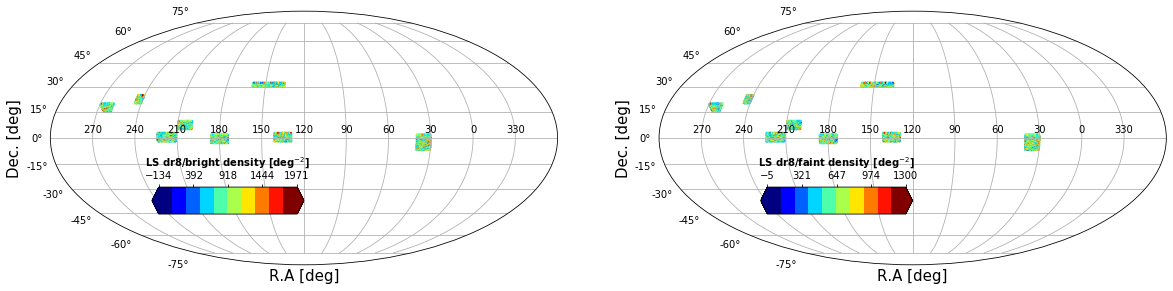

In [9]:
fig = plt.figure(figsize=(20, 15))
gs = gridspec.GridSpec(1,2)
    
org          = 120  # centre ra for mollweide plots
projection   = 'mollweide'
cm = mycmap(matplotlib.cm.jet, 10,0,1)
cmr= mycmap(matplotlib.cm.jet_r,10,0,1)

mollweide(hpdict=hpdict, namesel='bright', reg='svfields', projection=projection, n=0, org=org, cm=cm, fig=fig, gs=gs, cval=None)
mollweide(hpdict=hpdict, namesel='faint', reg='svfields', projection=projection, n=1, org=org, cm=cm, fig=fig, gs=gs, cval=None)
#mollweide(hpdict=hpdict, C=None ,namesel='any', reg='all', projection=projection, n=1, org=org, cm=cm, 
#          fig=fig, ws=ws, perc=(0.3,99.8), title='After linear weights', cval=(84, 2750))

file = '%s/skydens_%s_%s' %(pathdir, dr, 'svfields')
fig.savefig(file+'.png', bbox_inches = 'tight', pad_inches = 0)


## Flow charts: Nominal & Galaxy View

### MAIN

In [10]:
if survey == 'south': surveylab = 'DECaLS+DES'
elif survey == 'north': surveylab = 'BASS-MzLS'
    
flowTitle = dr+'_'+surveylab

Previous Cuts: (None)
Current Cuts: (BS|LG|GC)
Previous Cuts: (BS|LG|GC)
Current Cuts: (nobs)
Previous Cuts: (BS|LG|GC|nobs)
Current Cuts: (SG)
Previous Cuts: (BS|LG|GC|nobs|SG)
Current Cuts: (FMC2|CC)
Previous Cuts: (BS|LG|GC|nobs|SG|FMC2|CC)
Current Cuts: (QC_FM|QC_FI|QC_FF)


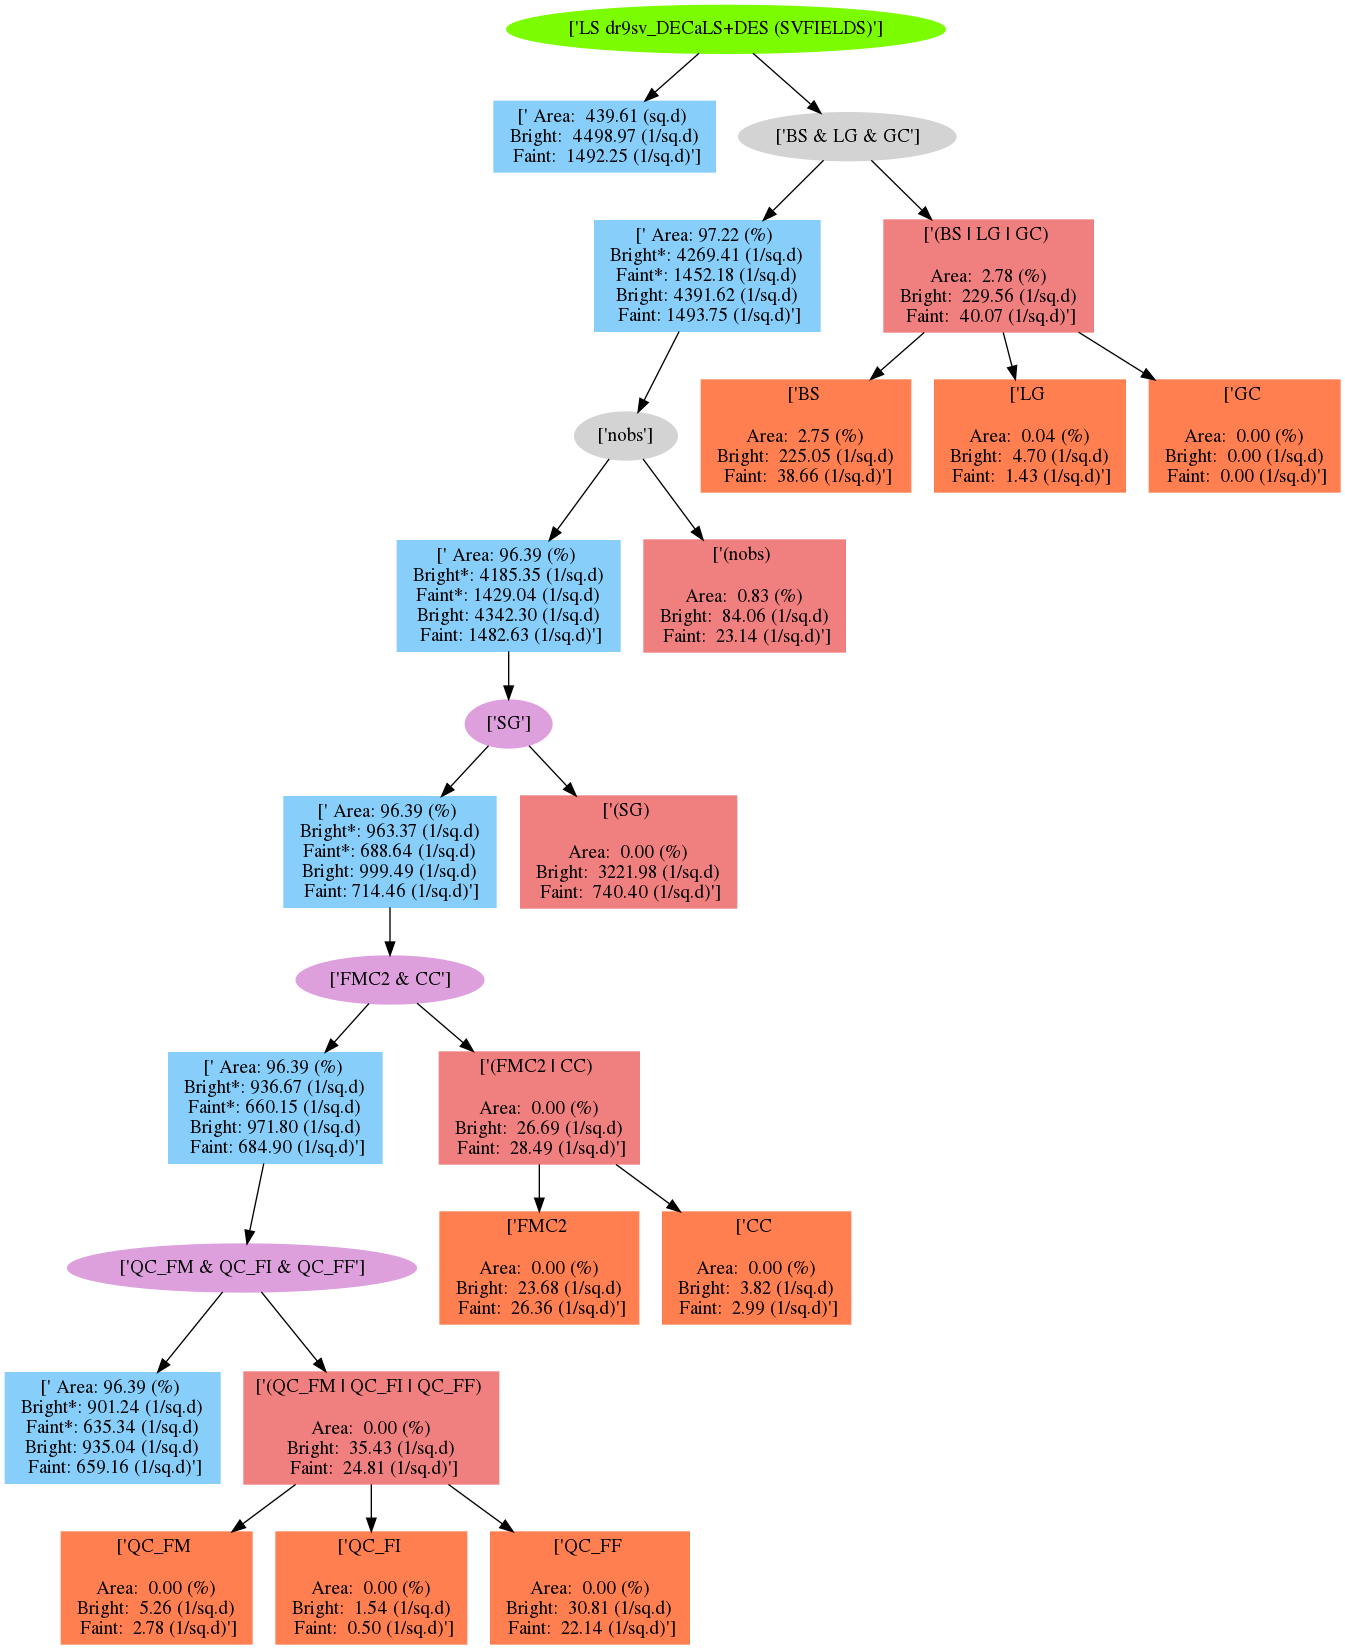

In [11]:
order = [['BS', 'LG', 'GC'], ['nobs'], ['SG'], ['FMC2', 'CC'], ['QC_FM', 'QC_FI', 'QC_FF']]

#reg is used to read the area of the proper region in hpdict0
flowNominal, _, _ = flow(cat=cat, hpdict=hpdict0, bgsmask=bgsmask(), rancuts=rancuts, order=order, reg='svfields', 
             regcat=cat_ex['svfields'], regran=ran_ex['svfields'], file='%s/flow_main_nominal_%s' %(pathdir, flowTitle), 
                         dr=flowTitle, program='main')

flowNominal

Previous Cuts: (None)
Current Cuts: (SG)
Previous Cuts: (SG)
Current Cuts: (BS|LG|GC)
Previous Cuts: (SG|BS|LG|GC)
Current Cuts: (nobs)
Previous Cuts: (SG|BS|LG|GC|nobs)
Current Cuts: (QC_FM|QC_FI|QC_FF)
Previous Cuts: (SG|BS|LG|GC|nobs|QC_FM|QC_FI|QC_FF)
Current Cuts: (FMC2|CC)


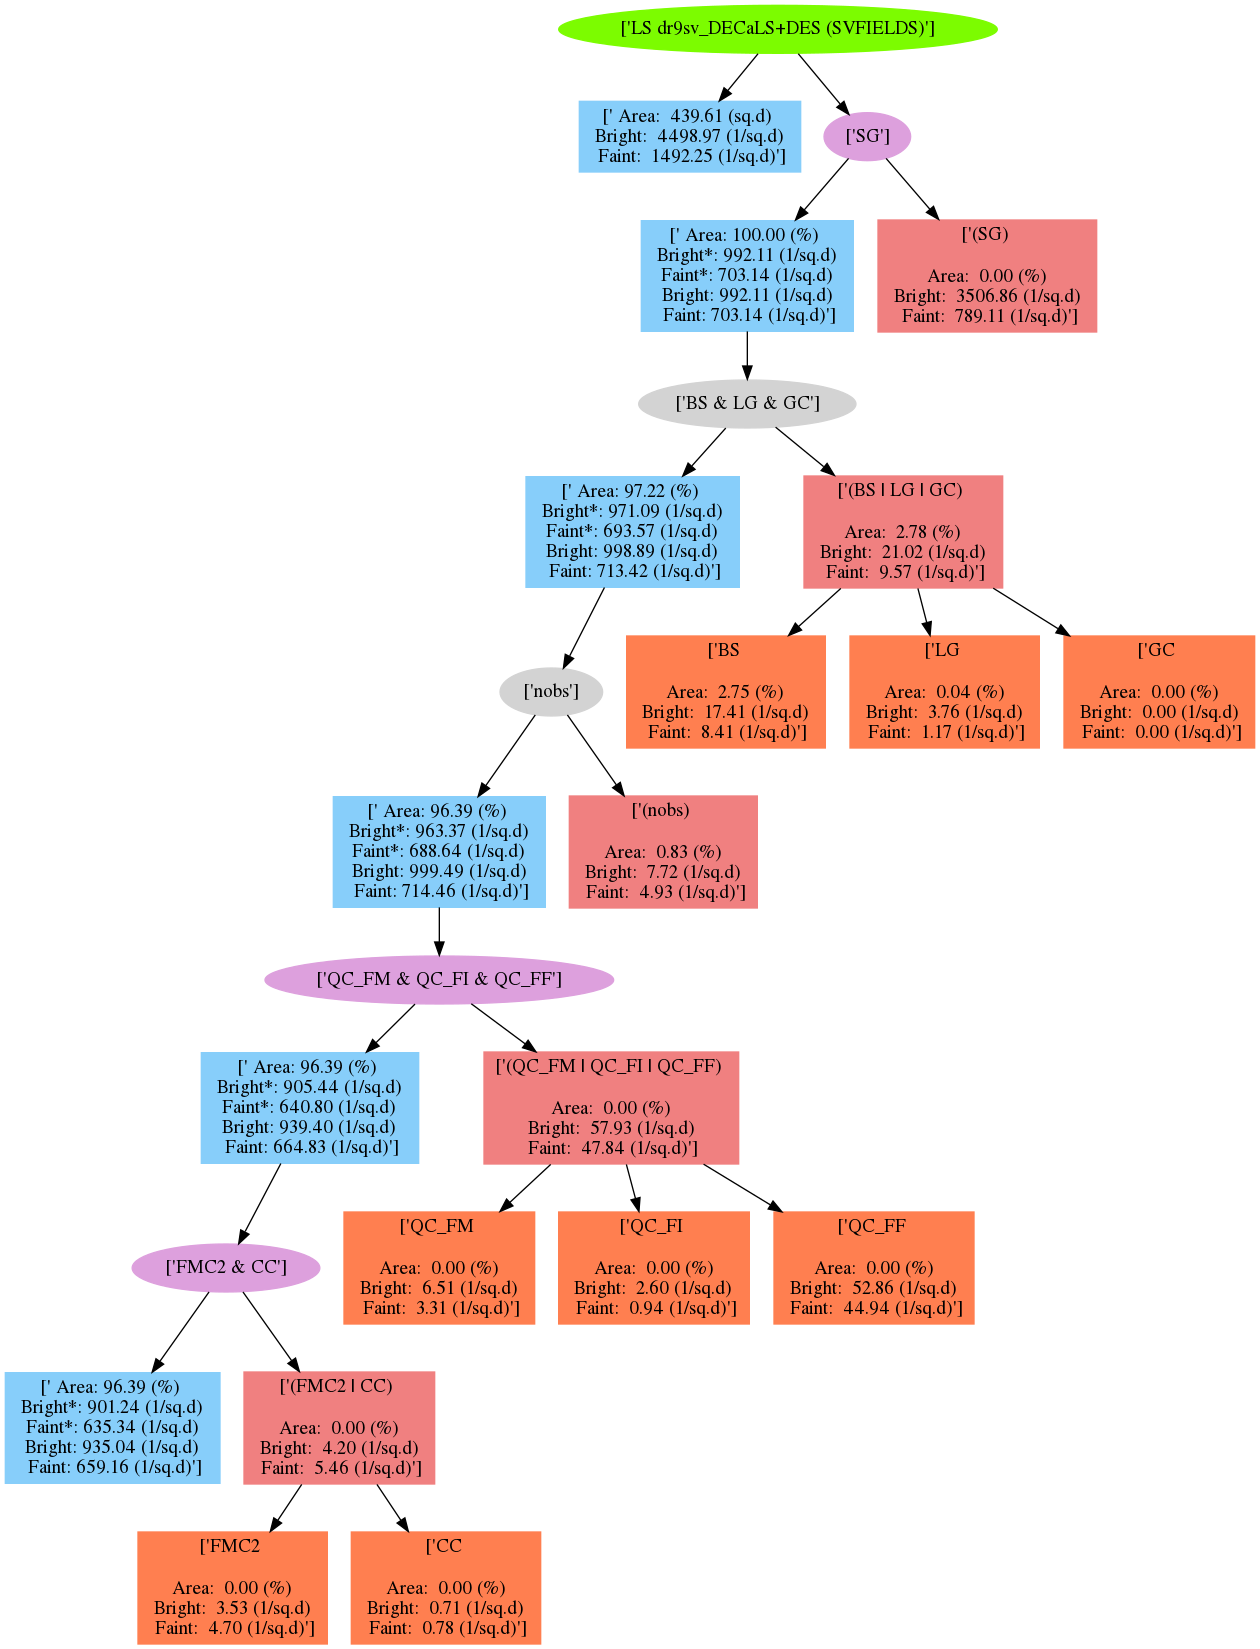

In [12]:
order = [ ['SG'], ['BS', 'LG', 'GC'], ['nobs'], ['QC_FM', 'QC_FI', 'QC_FF'], ['FMC2', 'CC']]

flowGalview, _, _ = flow(cat=cat, hpdict=hpdict0, bgsmask=bgsmask(), rancuts=rancuts, order=order, reg='svfields', 
             regcat=cat_ex['svfields'], regran=ran_ex['svfields'], file='%s/flow_main_galview_%s' %(pathdir,flowTitle), 
                         dr=flowTitle, program='main')

flowGalview

### SV

Previous Cuts: (None)
Current Cuts: (BS|GC)
Previous Cuts: (BS|GC)
Current Cuts: (nobs)
Previous Cuts: (BS|GC|nobs)
Current Cuts: (SGSV)
Previous Cuts: (BS|GC|nobs|SGSV)
Current Cuts: (CC)
Previous Cuts: (BS|GC|nobs|SGSV|CC)
Current Cuts: (QC_FM|QC_FI|QC_FF)


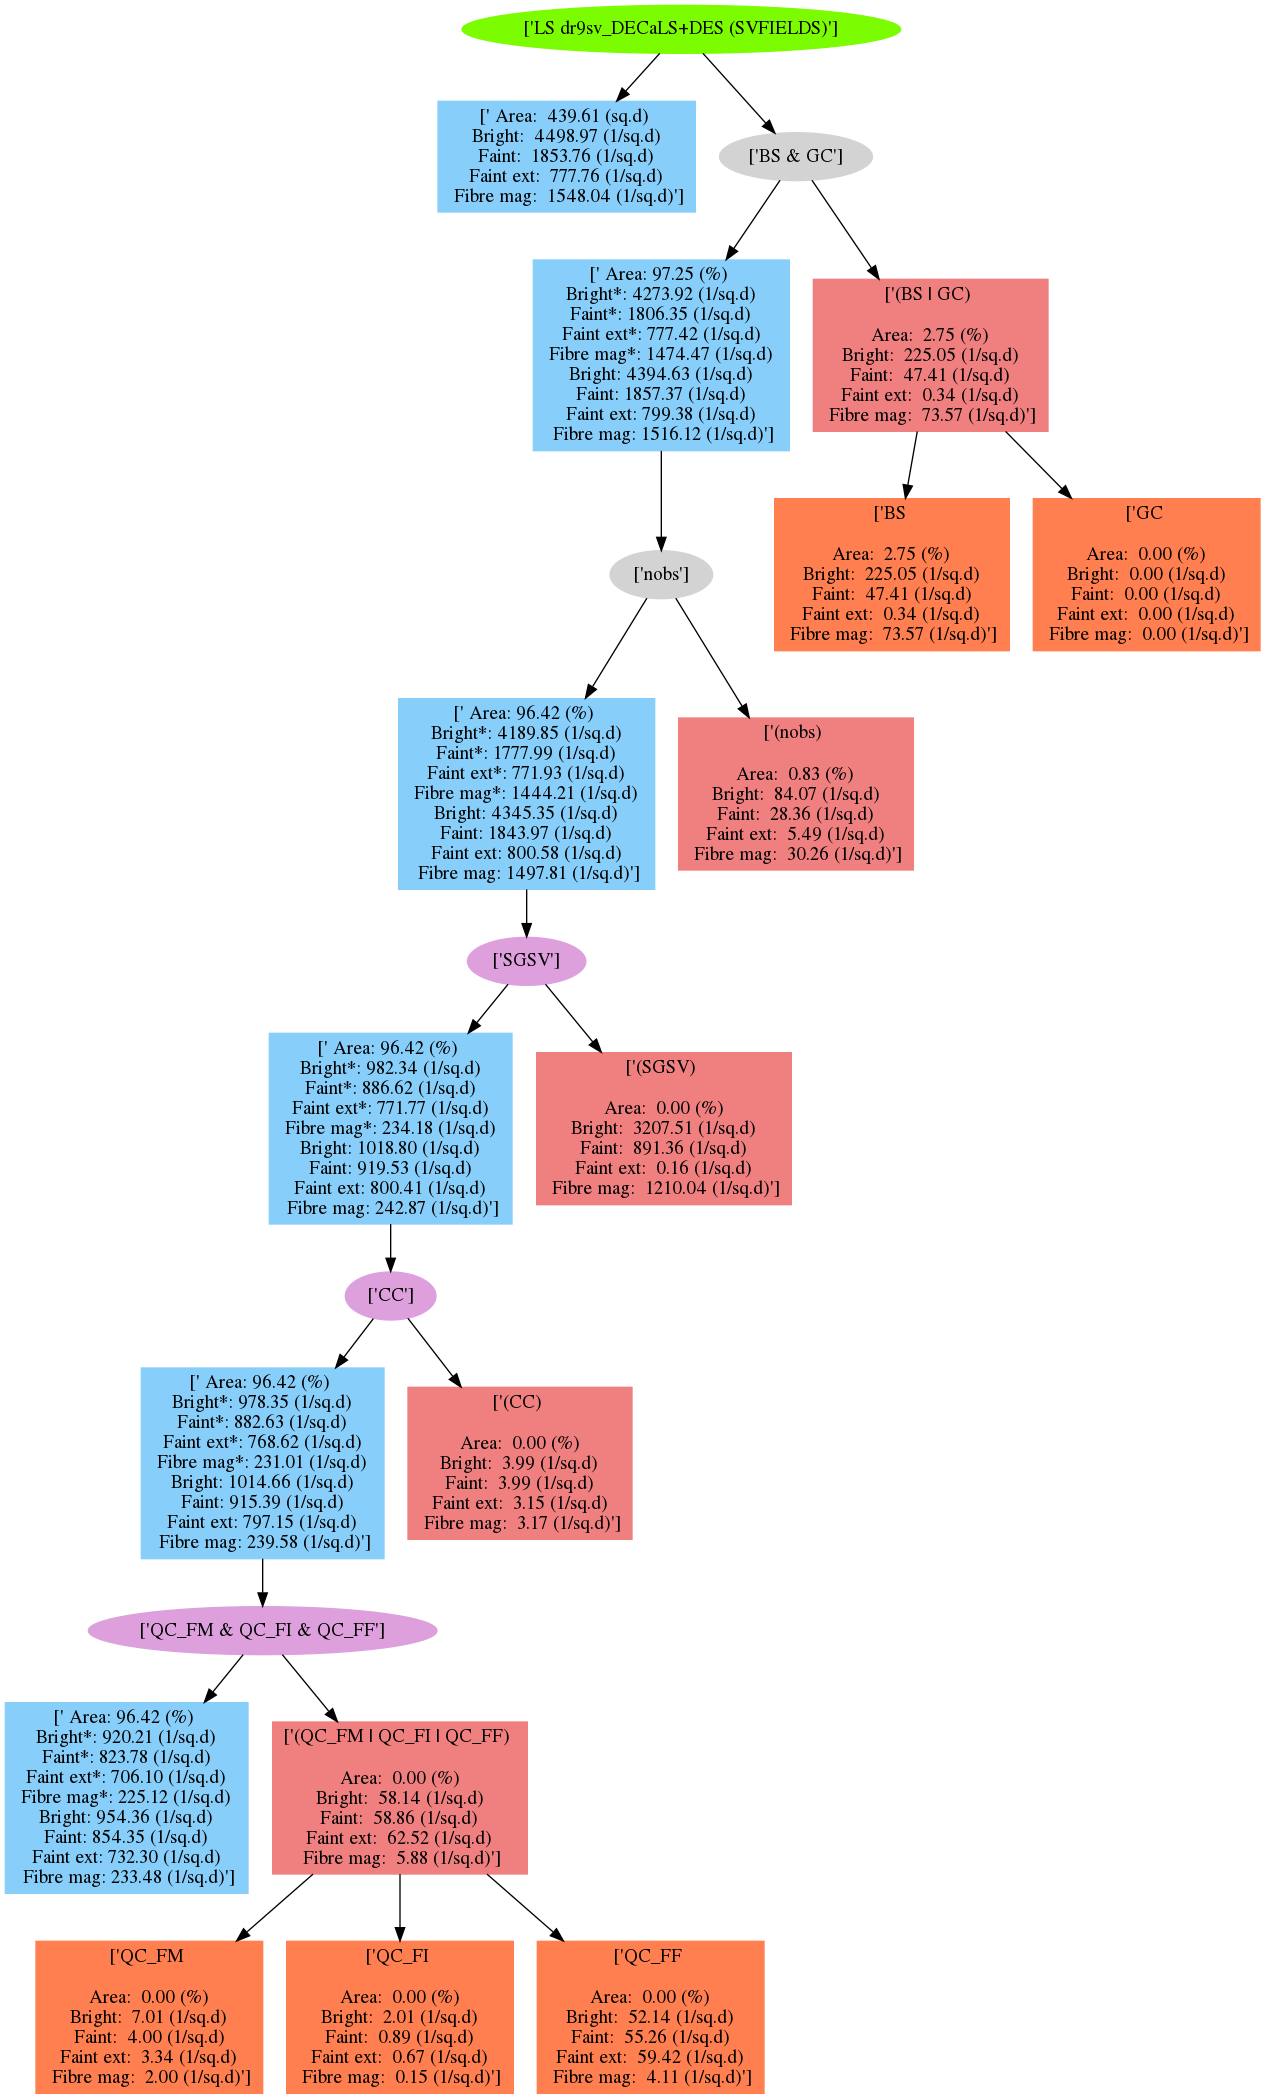

In [13]:
order = [['BS', 'GC'], ['nobs'], ['SGSV'], ['CC'], ['QC_FM', 'QC_FI', 'QC_FF']]

#reg is used to read the area of the proper region in hpdict0
flowNominal, _, _ = flow(cat=cat, hpdict=hpdict0, bgsmask=bgsmask(), rancuts=rancuts, order=order, reg='svfields', 
             regcat=cat_ex['svfields'], regran=ran_ex['svfields'], file='%s/flow_sv_nominal_%s' %(pathdir, flowTitle), 
                         dr=flowTitle, program='sv')

flowNominal

Previous Cuts: (None)
Current Cuts: (SGSV)
Previous Cuts: (SGSV)
Current Cuts: (BS|GC)
Previous Cuts: (SGSV|BS|GC)
Current Cuts: (nobs)
Previous Cuts: (SGSV|BS|GC|nobs)
Current Cuts: (QC_FM|QC_FI|QC_FF)
Previous Cuts: (SGSV|BS|GC|nobs|QC_FM|QC_FI|QC_FF)
Current Cuts: (CC)


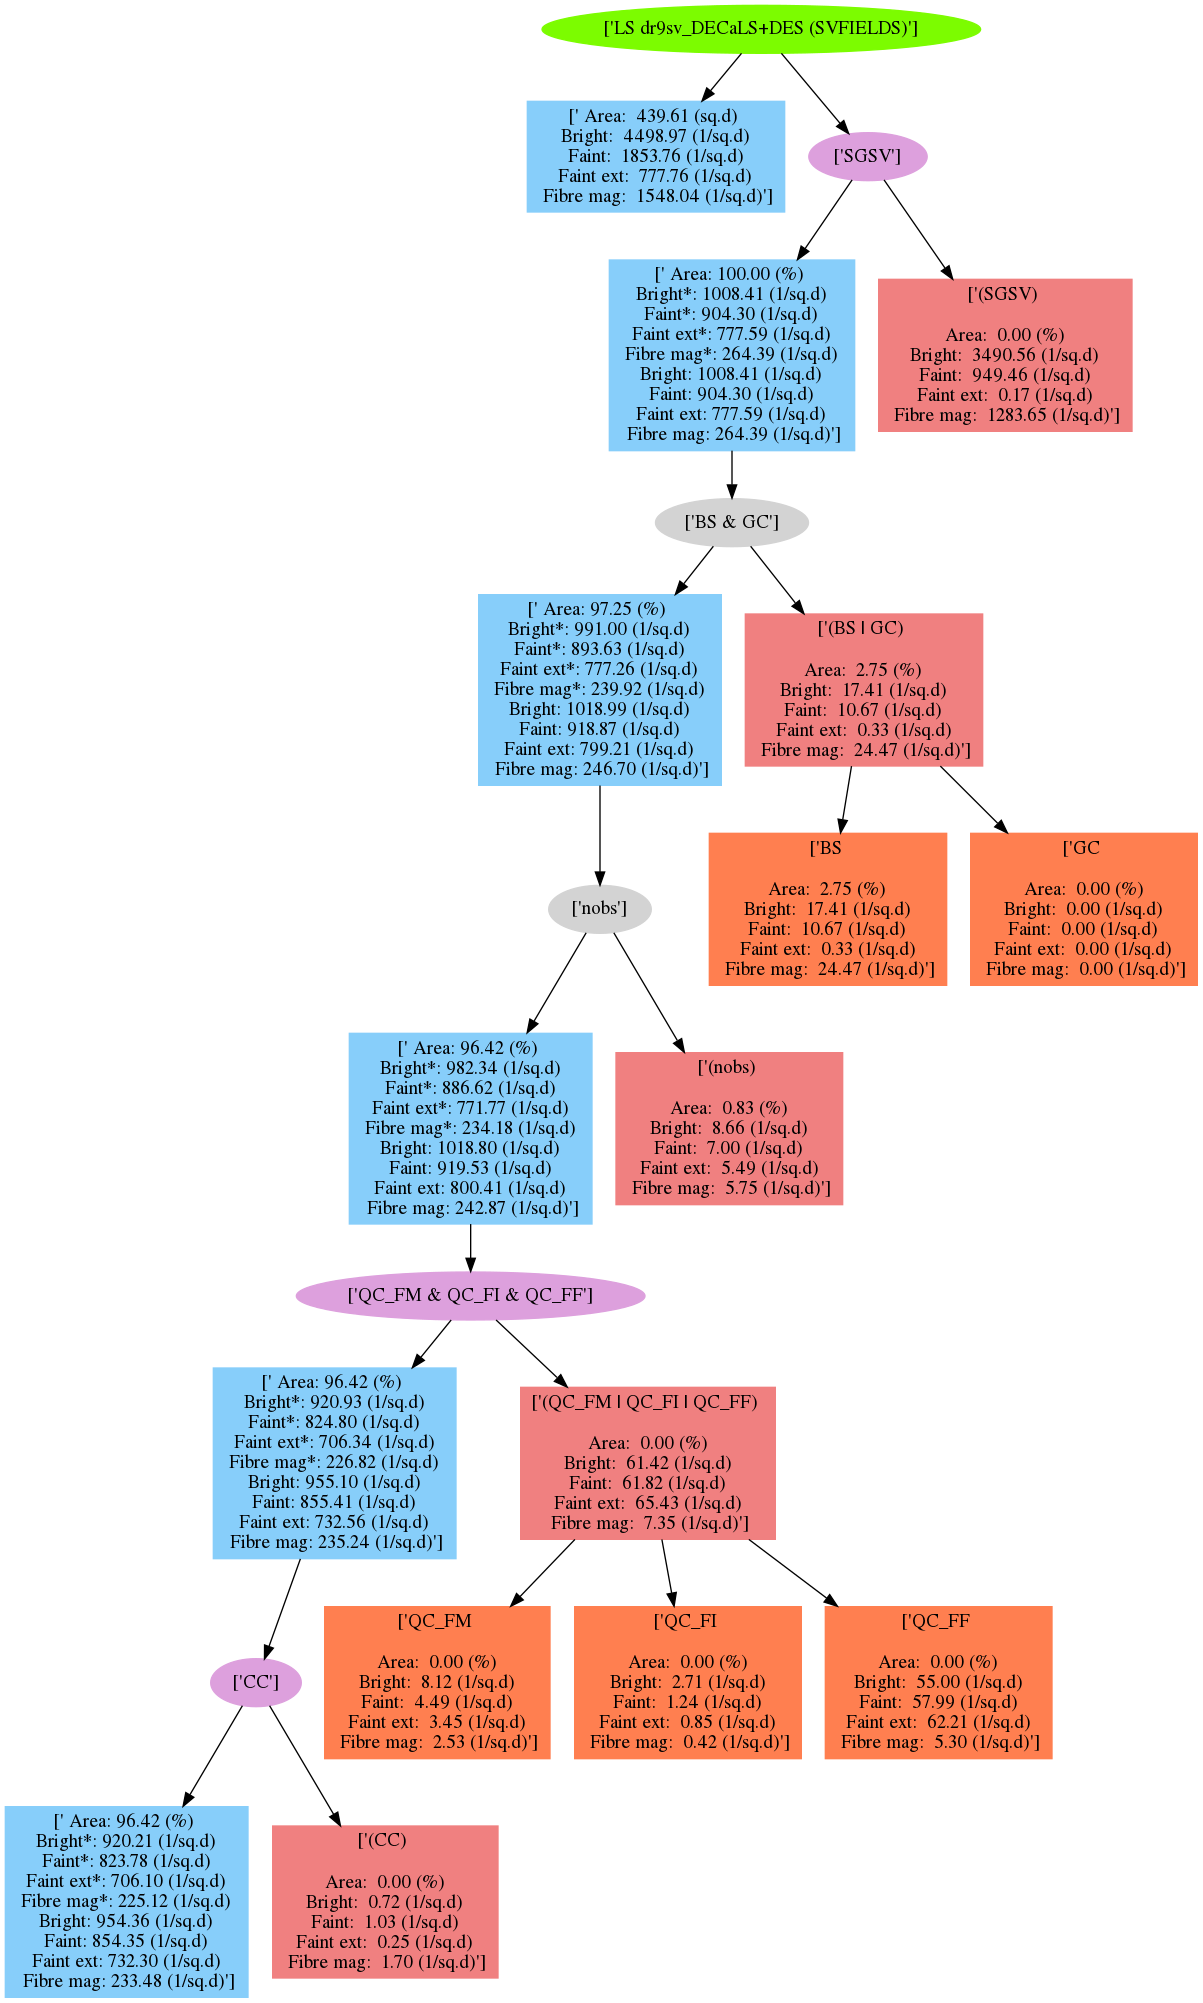

In [14]:
order = [['SGSV'], ['BS', 'GC'], ['nobs'], ['QC_FM', 'QC_FI', 'QC_FF'], ['CC']]
flowGalview, _, _ = flow(cat=cat, hpdict=hpdict0, bgsmask=bgsmask(), rancuts=rancuts, order=order, reg='svfields', 
             regcat=cat_ex['svfields'], regran=ran_ex['svfields'], file='%s/flow_sv_galview_%s' %(pathdir,flowTitle), 
                         dr=flowTitle, program='sv')

flowGalview

## fraction of PSF in BGS

In [15]:
bgs_any = ((cat['BGSBITS'] & 2**(20)) != 0)
bgs_b = ((cat['BGSBITS'] & 2**(21)) != 0)
bgs_f = ((cat['BGSBITS'] & 2**(22)) != 0)
psf = cat['TYPE'] == 'PSF'
gaia = cat['REF_CAT'] == 'G2'
area = hpdict['bgsarea_svfields']

In [16]:
print('bgs+psf: \t %.3f (1/sq.deg)' %(np.sum((bgs_any) & (psf))/area))
print('bgs+psf+gaia: \t %.3f (1/sq.deg)' %(np.sum((bgs_any) & (psf) & (gaia))/area))

bgs+psf: 	 7.252 (1/sq.deg)
bgs+psf+gaia: 	 1.477 (1/sq.deg)
